In [4]:
import pandas as pd
import os
import spacy
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
import scipy.stats as stats
import textstat
from sklearn.metrics.pairwise import cosine_similarity

In [170]:
import seaborn as sns

In [144]:
from transformers import BertTokenizer, TFBertModel
import random

In [10]:
os.chdir("../..")

We will be working with a Steam store dataset. Each row contains data for a game in the store. We will be restricting or dataset to small scale indie games. Successful games are those with more than 500 reviews. 

By restricting ourselves to the 'about the game' column, we are going to try to find group differences between those games that are successful, acording to the above metric, and those that are not. Our hypothesis is simple: Even though the reasons for a game's success are probably due to deeper factors that are not neatly reflected in the available data, to some extent, emulating the characteristics of a successful game's description could improve our chances of succeding, specially for low-budget, small scale games whose Steam pages are the main source of information for the potential buyer.

In [141]:
steam_df = pd.read_csv("data/raw/games.csv")

In [142]:
steam_df["total_reviews"] = steam_df["Positive"] + steam_df["Negative"]
steam_df["success"] = steam_df["total_reviews"] > 500
steam_success = steam_df[steam_df["success"] == 1]
steam_failure = steam_df[steam_df["success"] == 0]
steam_success_about = steam_success["About the game"]
steam_failure_about = steam_failure["About the game"]
steam_success_about.dropna(inplace=True)
steam_failure_about.dropna(inplace=True)

/var/folders/25/8m9ycrtx2kv84b8szslr4jfc0000gp/T/ipykernel_41289/2675616745.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_success_about.dropna(inplace=True)
/var/folders/25/8m9ycrtx2kv84b8szslr4jfc0000gp/T/ipykernel_41289/2675616745.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_failure_about.dropna(inplace=True)


In [13]:
# Loading a small Spacy model. That will do for now. We will load a large model when it comes to vectorizing words.
nlp = spacy.load("en_core_web_sm")

Starting with a simple frequency analysis. Our goal is breaking the texts into tokens, counting them and classifying them as parts-of-speech. Is there a significant difference in parts-of-speech frequency that could reflect a difference in text style?

In [154]:
def count_pos(text):
    # That's an auxiliary function. It counts the POS.
    doc = nlp(text)
    pos_counts = Counter([token.pos_ for token in doc])
    return pos_counts


def pos_frequency(texts):
    # That's our main function. We want to count the frequencies in each text and them average the whole corpus. Then, we can compare successful to not-successful games.
    all_pos_tags = set()
    for text in texts:
        all_pos_tags.update(count_pos(text).keys())

    all_pos_tags = list(all_pos_tags)

    dfs = []

    for i, text in enumerate(texts):
        pos_counts = count_pos(text)
        doc = nlp(text)
        tokens = [token.text for token in doc]

        # Calculate the frequency of each POS tag
        frequency_dict = {pos: pos_counts[pos] / len(tokens) for pos in all_pos_tags}

        df = pd.DataFrame(frequency_dict, index=[f"text_{i}"]).T

        dfs.append(df)

    # Concatenate all DataFrames along the columns
    frequency_df = pd.concat(dfs, axis=1)

    frequency_df = frequency_df.fillna(0)

    return frequency_df

Applying the function above to successful and unsuccessful games.

In [224]:
failure_sample = random.sample(list(steam_failure_about), 5000)
failure_pos_count = pos_frequency(failure_sample)
failure_pos_count.index = failure_pos_count.index.sort_values()
failure_mean_count = failure_pos_count.mean(axis=1)
failure_std_count = failure_pos_count.std(axis=1)

In [225]:
success_sample = random.sample(list(steam_success_about), 5000)
success_pos_count = pos_frequency(success_sample)
success_pos_count.index = success_pos_count.index.sort_values()
success_mean_count = success_pos_count.mean(axis=1)
success_std_count = success_pos_count.std(axis=1)

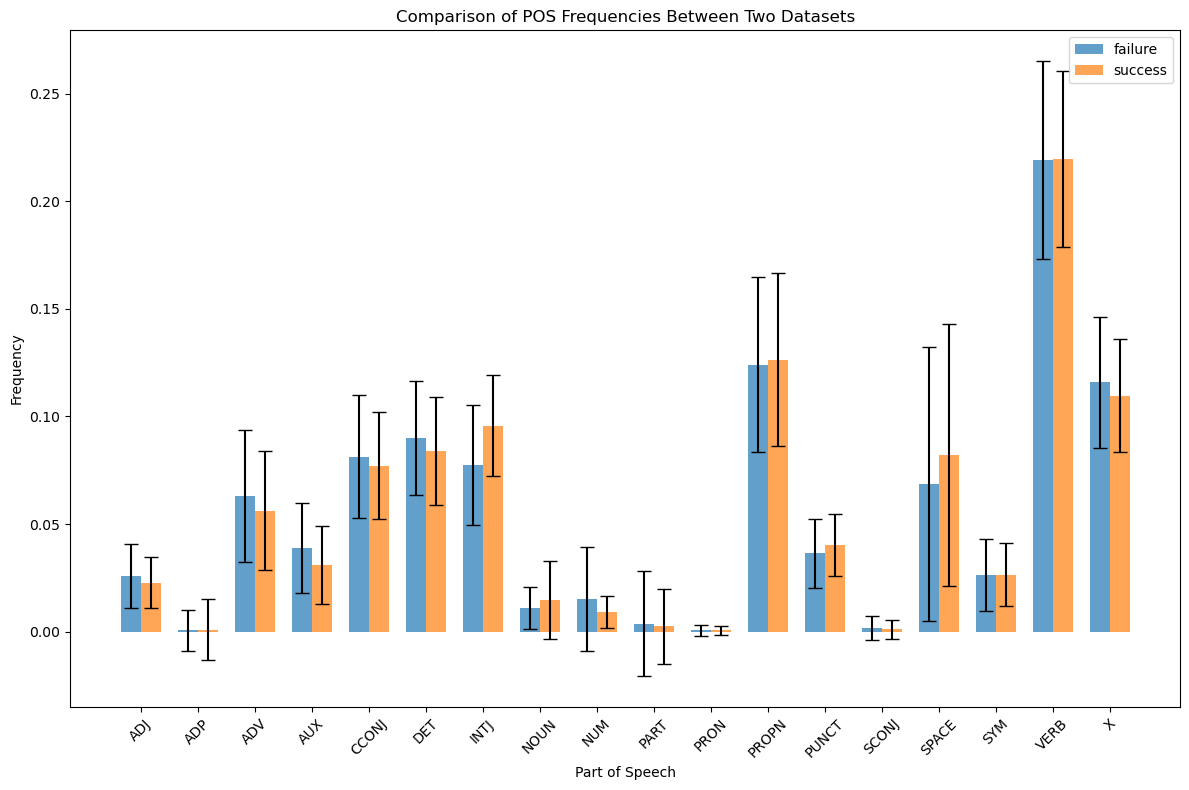

In [226]:
# Extract POS tags, means, and standard deviations
pos_tags = success_pos_count.index
means1 = failure_mean_count
stds1 = failure_std_count
means2 = success_mean_count
stds2 = success_std_count

# Set up the bar width and positions
bar_width = 0.35
index = np.arange(len(pos_tags))

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot dataset 1
bar1 = ax.bar(
    index, means1, bar_width, yerr=stds1, label="failure", alpha=0.7, capsize=5
)

# Plot dataset 2
bar2 = ax.bar(
    index + bar_width,
    means2,
    bar_width,
    yerr=stds2,
    label="success",
    alpha=0.7,
    capsize=5,
)

# Add labels, title, and legend
ax.set_xlabel("Part of Speech")
ax.set_ylabel("Frequency")
ax.set_title("Comparison of POS Frequencies Between Two Datasets")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(pos_tags, rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

Ploting shows that there are not many visible differences of POS frequency. Most of the means are within a standard deviation when compared to the opposite set of texts. We can give a value to the distance between the mean of successful and unsuccessful games by calculating the Z score. Interjections are a little more than half a standard deviation more common in the description for successful games.

In [227]:
abs((failure_mean_count - success_mean_count) / (failure_std_count)).sort_values(
    ascending=False
)

INTJ     0.657036
AUX      0.370193
NOUN     0.358232
NUM      0.246860
DET      0.240673
PUNCT    0.235854
ADV      0.223211
SPACE    0.210766
X        0.204623
ADJ      0.204450
CCONJ    0.147447
SCONJ    0.076867
PROPN    0.056614
PART     0.051363
ADP      0.038041
PRON     0.033581
VERB     0.010517
SYM      0.006544
dtype: float64

In [179]:
z_score = 0.38

# Calculate the cumulative probability
probability = stats.norm.cdf(z_score)

print(f"The probability of a Z-score of {z_score} or less is {probability:.4f}")

The probability of a Z-score of 0.38 or less is 0.6480


In [180]:
probability_greater = 1 - probability

print(
    f"The probability of a Z-score greater than {z_score} is {probability_greater:.4f}"
)

The probability of a Z-score greater than 0.38 is 0.3520


We can visualize what half std distance between the mean of two distributions means. There's a big overlap and a high probability that an event inside one of the distributions will fall inside the other distribution, making them hard to distinguish with certainty.

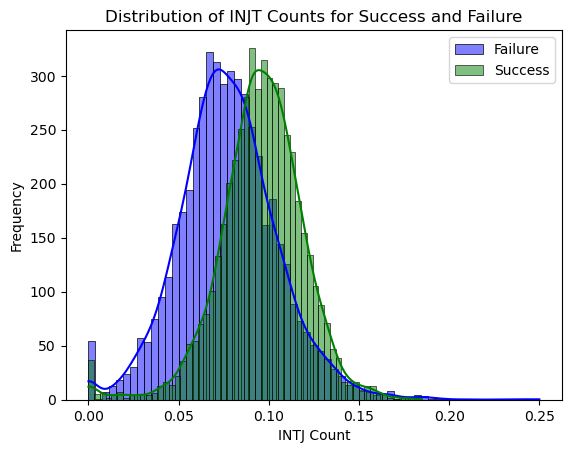

In [229]:
sns.histplot(failure_pos_count.T["INTJ"], color="blue", label="Failure", kde=True)
sns.histplot(success_pos_count.T["INTJ"], color="green", label="Success", kde=True)
plt.title("Distribution of INJT Counts for Success and Failure")
plt.xlabel("INTJ Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Next, we try to measure text complexity.

In [272]:
# Example pandas Series of texts
texts = success_sample

# Initialize lists to store aggregated metrics
all_token_counts = []
all_token_lengths = []
all_clause_counts = []
all_ttrs = []
all_flesch_reading_eases = []
all_gunning_fogs = []

# Process each text in the Series
for text in texts:
    doc = nlp(text)

    # Initialize lists to store metrics for the current text
    token_counts = []
    token_lengths = []
    clause_counts = []
    ttrs = []
    flesch_reading_eases = []
    gunning_fogs = []

    # Calculate complexity metrics for each sentence in the current text
    for sentence in doc.sents:
        words = [token.text for token in sentence if token.is_alpha]
        unique_words = set(words)
        ttr = len(unique_words) / len(words) if words else 0

        token_counts.append(len(sentence))
        token_lengths.append(np.mean([len(token) for token in sentence]))
        clause_counts.append(
            len(
                [
                    token
                    for token in sentence
                    if token.dep_ == "ccomp" or token.dep_ == "advcl"
                ]
            )
        )
        ttrs.append(ttr)
        flesch_reading_eases.append(textstat.flesch_reading_ease(sentence.text))
        gunning_fogs.append(textstat.gunning_fog(sentence.text))

    # Append the mean metrics of the current text to the aggregated lists
    all_token_counts.append(np.mean(token_counts))
    all_token_lengths.append(np.mean(token_lengths))
    all_clause_counts.append(np.mean(clause_counts))
    all_ttrs.append(np.mean(ttrs))
    all_flesch_reading_eases.append(np.mean(flesch_reading_eases))
    all_gunning_fogs.append(np.mean(gunning_fogs))

# Calculate overall means and standard deviations for all texts
mean_token_count = np.mean(all_token_counts)
std_token_count = np.std(all_token_counts)

mean_token_length = np.mean(all_token_lengths)
std_token_length = np.std(all_token_lengths)

mean_clause_count = np.mean(all_clause_counts)
std_clause_count = np.std(all_clause_counts)

mean_ttr = np.mean(all_ttrs)
std_ttr = np.std(all_ttrs)

mean_flesch_reading_ease = np.mean(all_flesch_reading_eases)
std_flesch_reading_ease = np.std(all_flesch_reading_eases)

mean_gunning_fog = np.mean(all_gunning_fogs)
std_gunning_fog = np.std(all_gunning_fogs)

# Print the summarized metrics
print(
    f"Mean number of tokens per sentence: {mean_token_count:.2f} (std: {std_token_count:.2f})"
)
print(f"Mean token length: {mean_token_length:.2f} (std: {std_token_length:.2f})")
print(
    f"Mean number of subordinate clauses per sentence: {mean_clause_count:.2f} (std: {std_clause_count:.2f})"
)
print(f"Mean Type-Token Ratio (TTR): {mean_ttr:.2f} (std: {std_ttr:.2f})")
print(
    f"Mean Flesch Reading Ease: {mean_flesch_reading_ease:.2f} (std: {std_flesch_reading_ease:.2f})"
)
print(f"Mean Gunning Fog Index: {mean_gunning_fog:.2f} (std: {std_gunning_fog:.2f})")

KeyboardInterrupt: 

We will explore the semantic space now. Here, the adjectives will be taken as a model.

In [12]:
nlp = spacy.load("en_core_web_lg")

In [232]:
def extract_adjectives(text):
    # This function extracts the adjectives in a text and lemmatizes it.
    doc = nlp(text)
    adjectives = [token.lemma_ for token in doc if token.pos_ == "ADJ"]
    return adjectives


def get_adjective_vectors(adjectives):
    vectors = [nlp(word).vector for word in adjectives if word in nlp.vocab]
    return vectors


def calculate_similarity(user_vectors, model_vectors):
    if not user_vectors or not model_vectors:
        return 0.0

    user_vector_avg = np.mean(user_vectors, axis=0)
    model_vector_avg = np.mean(model_vectors, axis=0)

    similarity = cosine_similarity([user_vector_avg], [model_vector_avg])[0][0]
    return similarity

In [54]:
# Example texts
user_text = steam_failure_about.iloc[60]
model_text = steam_success_about.iloc[1]

# Process texts
user_adjectives = extract_adjectives(user_text)
model_adjectives = extract_adjectives(model_text)

user_vectors = get_adjective_vectors(user_adjectives)
model_vectors = get_adjective_vectors(model_adjectives)

similarity_score = calculate_similarity(user_vectors, model_vectors)
print("Adjective Similarity Score:", similarity_score)

Adjective Similarity Score: 0.72757053


In [238]:
# Define a function to extract adjectives from a single text
def extract_adjectives(text):
    if pd.isna(text):
        return []
    doc = nlp(text)
    adjectives = [token.lemma_ for token in doc if token.pos_ == "ADJ"]
    return adjectives

In [ ]:
adjectives_count = [token.lemma_ for token in doc if token.pos_ == "ADJ"]

In [237]:
success_sample

['Home Sweet Home: Survive is a brand new asymmetrical game that consists of 1 Specter hunting 4 survivors in an arena. There are two core gameplays depended on the role players take. The Specter is to strategically hunt 4 Survivors letting no one escape, and not being killed by survivors. Each Specter will have different stats and special abilities offering various ways of hunting survivors. The survivors have to cooperate to complete the objective. Each character will have different stats and unique abilities supporting each role of play - decoy, damage, or perform the rituals. Things will drastically change after the objective is completed. The game will test personal dilemma choosing either teaming up to eliminate the Specter or saving own self by leaving the arena. escaping the Hindrance, or be the Specter and hunt and collect souls. Key Features · Multiplayer – Enjoy the game in multiplayer, cooperating with other survivors or being a lone wolf hunting down survivors · Differenti

In [242]:
# Example pd.Series of texts
texts = success_sample

# Apply the function to the entire pd.Series to get adjectives for each text
all_adjectives = pd.Series(texts).apply(extract_adjectives)

# Flatten the list of lists into a single list
flat_adjectives = [adj for sublist in all_adjectives for adj in sublist]

# Count the occurrences of each adjective
adjective_counts = Counter(flat_adjectives)

# Convert the counter to a DataFrame for better visualization
adjective_df_success = pd.DataFrame(
    adjective_counts.items(), columns=["Adjective", "Count"]
)

print(adjective_df_success)

         Adjective  Count
0              new   6702
1     asymmetrical     10
2        different   2472
3          special    751
4          various    762
...            ...    ...
6064     reductive      1
6065       genital      1
6066       flaccid      1
6067        wiggly      1
6068   unappealing      1

[6069 rows x 2 columns]


In [243]:
# Example pd.Series of texts
texts = failure_sample

# Apply the function to the entire pd.Series to get adjectives for each text
all_adjectives = pd.Series(texts).apply(extract_adjectives)

# Flatten the list of lists into a single list
flat_adjectives = [adj for sublist in all_adjectives for adj in sublist]

# Count the occurrences of each adjective
adjective_counts = Counter(flat_adjectives)

# Convert the counter to a DataFrame for better visualization
adjective_df_failure = pd.DataFrame(
    adjective_counts.items(), columns=["Adjective", "Count"]
)

print(adjective_df_failure)

       Adjective  Count
0           left    118
1           long    334
2        various    795
3      dangerous    305
4        certain    251
...          ...    ...
5255           🙋      1
5256  unplayable      1
5257      spiffy      1
5258     parried      1
5259    limorian      1

[5260 rows x 2 columns]


Let's isolate the top adjectives that occur in one set, but not in the other.

In [253]:
set(adjective_df_success.nlargest(150, "Count")["Adjective"]) - set(
    adjective_df_failure.nlargest(150, "Count")["Adjective"]
)

{'authentic',
 'brutal',
 'competitive',
 'creative',
 'customizable',
 'exclusive',
 'famous',
 'fresh',
 'global',
 'heavy',
 'historical',
 'iconic',
 'incredible',
 'legendary',
 'mighty',
 'military',
 'multi',
 'numerous',
 'official',
 'popular',
 'social',
 'stunning',
 'traditional'}

In [254]:
set(adjective_df_failure.nlargest(150, "Count")["Adjective"]) - set(
    adjective_df_success.nlargest(150, "Count")["Adjective"]
)

{'2d',
 'basic',
 'careful',
 'casual',
 'colorful',
 'cool',
 'crazy',
 'current',
 'cute',
 'friendly',
 'fun',
 'future',
 'hot',
 'like',
 'limited',
 'magic',
 'normal',
 'previous',
 'retro',
 'safe',
 'second',
 'third',
 'unknown'}

We will train the Word2Vec vectorizer on our whole dataset. Then, we can extract the embeddings for our list of adjectives.

In [246]:
pre_processed_reviews = steam_df["About the game"].dropna().apply(simple_preprocess)
model = Word2Vec(
    pre_processed_reviews, vector_size=100, window=5, min_count=1, workers=4
)

In [273]:
# sanity check
print(model.wv.similarity(w1="brazil", w2="argentina"))

AttributeError: 'RobertaForSequenceClassification' object has no attribute 'wv'

In [257]:
words_success = {
    "authentic",
    "brutal",
    "competitive",
    "creative",
    "customizable",
    "exclusive",
    "famous",
    "fresh",
    "global",
    "heavy",
    "historical",
    "iconic",
    "incredible",
    "legendary",
    "mighty",
    "military",
    "multi",
    "numerous",
    "official",
    "popular",
    "social",
    "stunning",
    "traditional",
}

In [258]:
words_failure = {
    "2d",
    "basic",
    "careful",
    "casual",
    "colorful",
    "cool",
    "crazy",
    "current",
    "cute",
    "friendly",
    "fun",
    "future",
    "hot",
    "like",
    "limited",
    "magic",
    "normal",
    "previous",
    "retro",
    "safe",
    "second",
    "third",
    "unknown",
}

In [249]:
# Get the vectors for the words in the list and compute the mean vector
vectors_success = [
    model.wv[word] for word in filtered_df_succces["Adjective"] if word in model.wv
]
mean_vector_success = np.mean(vectors_success, axis=0)

In [250]:
# Get the vectors for the words in the list and compute the mean vector
vectors_failure = [
    model.wv[word] for word in filtered_failure_df["Adjective"] if word in model.wv
]
mean_vector_failure = np.mean(vectors_failure, axis=0)

Similarity is high between these two vectors because the most common adjectives in a language are used in a wide variety of contexts. 

In [251]:
cosine_similarity(
    mean_vector_success.reshape(1, -1), mean_vector_failure.reshape(1, -1)
)[0][0]

0.9558777

But for those that differ, the degree of similarity is lower. They are not opposites, though.

In [260]:
vectors_success = [model.wv[word] for word in words_success if word in model.wv]
mean_vector_success = np.mean(vectors_success, axis=0)
vectors_failure = [model.wv[word] for word in words_failure if word in model.wv]
mean_vector_failure = np.mean(vectors_failure, axis=0)
cosine_similarity(
    mean_vector_success.reshape(1, -1), mean_vector_failure.reshape(1, -1)
)[0][0]

0.39644107

# Emotion multi-label classifier

In [262]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

In [264]:
# Load the model and tokenizer
model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


# Define a function to split text into chunks
def split_into_chunks(text, max_length=512):
    tokens = tokenizer(text, return_tensors="pt", truncation=False)
    input_ids = tokens["input_ids"][0]
    chunk_size = max_length - 2  # accounting for special tokens
    chunks = [
        input_ids[i : i + chunk_size] for i in range(0, len(input_ids), chunk_size)
    ]
    return [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]

In [266]:
# Apply splitting to your texts
texts = random.sample(list(steam_success_about), 500)
chunked_texts_success = [chunk for text in texts for chunk in split_into_chunks(text)]

In [267]:
# Apply splitting to your texts
texts = random.sample(list(steam_failure_about), 500)
chunked_texts_failure = [chunk for text in texts for chunk in split_into_chunks(text)]

In [268]:
pipe = pipeline(
    "text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None
)

In [269]:
success_emotions = pipe(chunked_texts_success)

In [271]:
failure_emotions = pipe(chunked_texts_failure)